In [23]:
import glob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_to_library = '../FragmentLibrary'

# list of folders for each subpocket
folders = glob.glob(path_to_library+'/*')
subpockets = [folder[-2:] for folder in folders]
subpockets

['FP', 'B2', 'AP', 'SE', 'B1', 'GA']

In [3]:
# read data

data = pd.DataFrame()

# iterate over subpockets
for i, folder in enumerate(folders):
    
    subpocket = subpockets[i]
    
    file = folder+'/'+subpocket+'.sdf' 
    df = pd.DataFrame()
    suppl = Chem.SDMolSupplier(file, removeHs=False)
        
    fragments = []
    smiles = []
    groups = []
    families = []
    kinases = []

    for frag in suppl:
        
        # delete dummy atoms
        du = Chem.MolFromSmiles('*')
        h = Chem.MolFromSmiles('[H]', sanitize=False)
        fixed_frag = AllChem.ReplaceSubstructs(frag, du, h, replaceAll=True)[0]
        fixed_frag = Chem.RemoveHs(fixed_frag)
        # remove duplicates based on smiles
        #if s in smiles:
        #    continue
        s = Chem.MolToSmiles(fixed_frag)
        smiles.append(s)
        fragments.append(Chem.MolFromSmiles(s))
        
        groups.append(frag.GetProp('group'))
        families.append(frag.GetProp('family'))
        kinases.append(frag.GetProp('kinase'))
    
    df['fragment'] = fragments
    df['smiles'] = smiles
    df['subpocket'] = subpocket
    df['group'] = groups
    df['family'] = families
    df['kinase'] = kinases
    
    data = data.append(df)
    
data = data.reset_index(drop=True)
data.shape

(6798, 6)

In [4]:
df_AP = data[data.subpocket=='AP']
df_FP = data[data.subpocket=='FP']
df_SE = data[data.subpocket=='SE']
df_GA = data[data.subpocket=='GA']
df_B1 = data[data.subpocket=='B1']
df_B2 = data[data.subpocket=='B2']

In [5]:
df_AP.drop_duplicates(subset='smiles').shape

(1116, 6)

In [6]:
df_AP.smiles.nunique()

1116

In [7]:
groups = df_AP.group.unique()
groups

array(['Other', 'TK', 'TKL', 'AGC', 'CMGC', 'CAMK', 'CK1', 'STE'],
      dtype=object)

Calculate number of fragments and unique fragments per kinase group per subpocket.

In [8]:
n_frags = {}
n_unique_frags = {}

for subpocket in subpockets:
    
    df = data[data.subpocket==subpocket]
    
    n_frags_group = {}
    n_unique_frags_group = {}
    
    for group in groups:
        
        df_group = df[df.group==group]
        n = df_group.shape[0]
        n_unique = df_group.smiles.nunique()
        
        n_frags_group[group] = n
        n_unique_frags_group[group] = n_unique
        
    n_frags[subpocket] = n_frags_group
    n_unique_frags[subpocket] = n_unique_frags_group


In [9]:
n_frags = pd.DataFrame(data=n_frags)
n_frags.loc["Total"] = n_frags.sum(axis=0)
n_frags["Total"] = n_frags.sum(axis=1)

In [10]:
n_unique_frags = pd.DataFrame(data=n_unique_frags)
n_unique_frags.loc["Total"] = n_unique_frags.sum(axis=0)
n_unique_frags["Total"] = n_unique_frags.sum(axis=1)

In [11]:
df_n_frags = pd.concat([n_frags,n_unique_frags], axis=1, keys=['All', 'Unique'])
df_n_frags.stack(0)

AP   B1   B2    FP    GA    SE  Total
AGC   All      141    0   62   117    36    16    372
      Unique    79    0   37    84    18    12    230
CAMK  All      352    2   13   202   152   148    869
      Unique   266    2   12   122    79    98    579
CK1   All       47    0    0    22    32    19    120
      Unique    38    0    0    17    11    13     79
CMGC  All      759   12   89   490   302   435   2087
      Unique   406    8   40   273   151   186   1064
Other All      234    7   18   162    87   200    708
      Unique   135    7   10    86    45   110    393
STE   All      106   11   10    53    60    68    308
      Unique    68    9    8    39    39    50    213
TK    All      616   42   44   493   259   450   1904
      Unique   297   18   23   283    97   243    961
TKL   All      140   32    1    82   107    68    430
      Unique    88   14    1    55    55    49    262
Total All     2395  106  237  1621  1035  1404   6798
      Unique  1377   58  131   959   495   761   3781

In [16]:
n_frags

,FP,B2,AP,SE,B1,GA,Total
AGC,117,62,141,16,0,36,372
CAMK,202,13,352,148,2,152,869
CK1,22,0,47,19,0,32,120
CMGC,490,89,759,435,12,302,2087
Other,162,18,234,200,7,87,708
STE,53,10,106,68,11,60,308
TK,493,44,616,450,42,259,1904
TKL,82,1,140,68,32,107,430
Total,1621,237,2395,1404,106,1035,6798


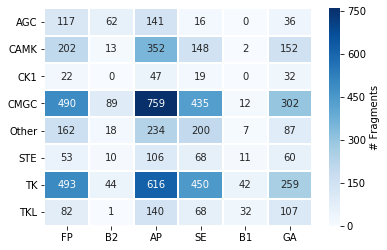

In [22]:
sns.heatmap(n_frags.drop(['Total'], axis=0).drop(['Total'], axis=1), linewidths=1, annot=True, cbar_kws={"label": "# Fragments"}, cmap="Blues", fmt='g')
plt.show()

In [12]:
groups = df_AP.group.unique()

In [13]:
# unique fragments per group per subpocket
for group in groups:
    
    df = data[data.group==group]
    n = 0
    
    for subpocket in subpockets:
        
        n_s = df[df.subpocket==subpocket].smiles.nunique()
        n += n_s
    
    print(group, n)

Other 393
TK 961
TKL 262
AGC 230
CMGC 1064
CAMK 579
CK1 79
STE 213
